# Membrete - Ejercicio en BigML

<img src="https://upload.wikimedia.org/wikipedia/commons/6/6c/Javeriana.svg" alt="Logo Javeriana" width="150"/>

- **Nombre:** Alberto Luis Vigna Arroyo.
- **Universidad:** Pontificia Universidad Javeriana.
- **Materia:** Procesamiento de Datos a Gran Escala.
- **Nombre del Profesor:** John Corredor.
- **Correo Electrónico:** a-vigna@javeriana.edu.co
- **Fecha:** 05 de febrero de 2024.
- **Lugar:** Bogotá, Colombia.

# Contexto:

- __Que es un Ictus?:__ 
- El ictus, también conocido como accidente cerebrovascular (ACV), es una enfermedad cerebrovascular que afecta a los vasos sanguíneos que suministran sangre al cerebro. Es la segunda causa de muerte en el mundo y la primera de discapacidad adquirida en el adulto. Se produce por la interrupción del flujo sanguíneo cerebral, ya sea por la obstrucción de una arteria (ictus isquémico) o por la rotura de un vaso sanguíneo (ictus hemorrágico). _Fuente: https://es.wikipedia.org/wiki/Ictus_

# Descripción del Dataset:

- __Nombre del Dataset:__ Health00.csv
- __Link al Dataset:__ https://raw.githubusercontent.com/corredor-john/EDA_Varios/main/Health00.csv

### Descripción del Dataset:
- __id__: Identificador.
- __gender:__ Género del paciente.
- __age:__ Edad del paciente.
- __hypertension__ Si el paciente sufre de hipertensión.
- __heart_disease:__ Si el paciente sufre de enfermedades del corazón.
- __ever_married:__ Si el paciente ha estado casado.
- __work_type:__ Tipo de trabajo del paciente.
- __Residence_type:__ Tipo de residencia donde vive el paciente.
- __avg_glucose_level:__ Nivel promedio de glucosa en sangre.
- __bmi:__ Índice de masa corporal.
- __smoking_status:__ Estado de fumador del paciente (nunca fumó, fumador, ex fumador).
- __stroke:__ Si el paciente ha sufrido un ictus.

In [88]:
# Importar librerías
import pyspark

# Librería para trabajar con Spark
from pyspark import SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import *
from pyspark.sql.types import *

# Libreía para trabajar con Spark ML
from pyspark.ml import *
from pyspark.ml.feature import StringIndexer, VectorAssembler, QuantileDiscretizer
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Librería de Skelarn para trabajar con métricas
from sklearn.metrics import roc_curve, auc


# Librería para trabajar con números
import numpy as np

# Librería para trabajar con gráficos
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Librería para trabajar con Pandas
import pandas as pd

In [89]:
spark = SparkSession.builder.appName("Ictus").getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=Ictus>

In [90]:
import requests
import pandas as pd
from io import StringIO

# URL del dataset
url = "https://raw.githubusercontent.com/corredor-john/EDA_Varios/main/Health00.csv"

# Desactivar la verificación de SSL
response = requests.get(url, verify=False)

# Asegurarse de que la petición fue exitosa
if response.status_code == 200:
    # Convertir el contenido del response a un objeto StringIO (se comporta como un archivo)
    data = StringIO(response.text)
    
    # Leer el dataset CSV en un DataFrame de Pandas
    pandasDF = pd.read_csv(data)
    
    # Convertir el DataFrame de Pandas a un DataFrame de Spark
    mlDFTemp = spark.createDataFrame(pandasDF)
    
    # Mostrar el esquema del DataFrame (primeras 5 filas)
    display(mlDFTemp.limit(5).toPandas())
else:
    print(f"Error al descargar el archivo: {response.status_code}")


/Users/tars/Desktop/UNIVERSITY/7mo Semestre/Procesamiento de Datos a Gran Escala/Talleres/Talleres-ProcesamientoDeDatosAGranEscala/.venv/lib/python3.12/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'raw.githubusercontent.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [91]:
mlDF = mlDFTemp

mlDF.printSchema()

root
 |-- id: long (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: long (nullable = true)
 |-- heart_disease: long (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: long (nullable = true)



In [92]:
# Se eliminan las columnas que no se van a utilizar (como el id).
mlDF = mlDF.drop("id")

# Se eliminan las filas que contienen valores nulos.
mlDF.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in mlDF.columns]).show()

+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi|smoking_status|stroke|
+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|     0|  0|           0|            0|           0|        0|             0|                0|201|             0|     0|
+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+



Se puede observar que casi no hay valores nulos en el datase, pero en la columna "BMI" hay 201 valores nulos.

In [93]:
from pyspark.sql.functions import col, isnan, when

# Promedio de BMI (sin tener en cuenta los valores nulos)
mean_bmi = mlDF.select(mean("bmi")).collect()[0][0]

print(f"Promedio de BMI: {mean_bmi}")

# Reemplazar los valores 'NaN' y nulos en la columna "bmi" por 21.2
mlDF = mlDF.withColumn("bmi", when(isnan("bmi") | col("bmi").isNull(), mean_bmi).otherwise(col("bmi")))

# Verificar que ya no hayan valores nulos o 'NaN' en la columna "bmi"
mlDF.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in mlDF.columns]).show()


Promedio de BMI: nan
+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi|smoking_status|stroke|
+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|     0|  0|           0|            0|           0|        0|             0|                0|201|             0|     0|
+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+



In [94]:
# Categorías 
mlDF.groupBy("gender").count().show()
mlDF.groupBy("smoking_status").count().show()
mlDF.groupBy("ever_married").count().show()
mlDF.groupBy("work_type").count().show()
mlDF.groupBy("Residence_type").count().show()

+------+-----+
|gender|count|
+------+-----+
|Female| 2994|
|  Male| 2115|
| Other|    1|
+------+-----+

+---------------+-----+
| smoking_status|count|
+---------------+-----+
|         smokes|  789|
|        Unknown| 1544|
|   never smoked| 1892|
|formerly smoked|  885|
+---------------+-----+

+------------+-----+
|ever_married|count|
+------------+-----+
|          No| 1757|
|         Yes| 3353|
+------------+-----+

+-------------+-----+
|    work_type|count|
+-------------+-----+
| Never_worked|   22|
|Self-employed|  819|
|      Private| 2925|
|     children|  687|
|     Govt_job|  657|
+-------------+-----+

+--------------+-----+
|Residence_type|count|
+--------------+-----+
|         Urban| 2596|
|         Rural| 2514|
+--------------+-----+



In [95]:
# Se elimina el "other" de la columna "gender"
mlDF = mlDF.filter(mlDF.gender != "Other")

# Comprobar que se eliminó el valor "Other"
mlDF.groupBy("gender").count().show()

+------+-----+
|gender|count|
+------+-----+
|Female| 2994|
|  Male| 2115|
+------+-----+



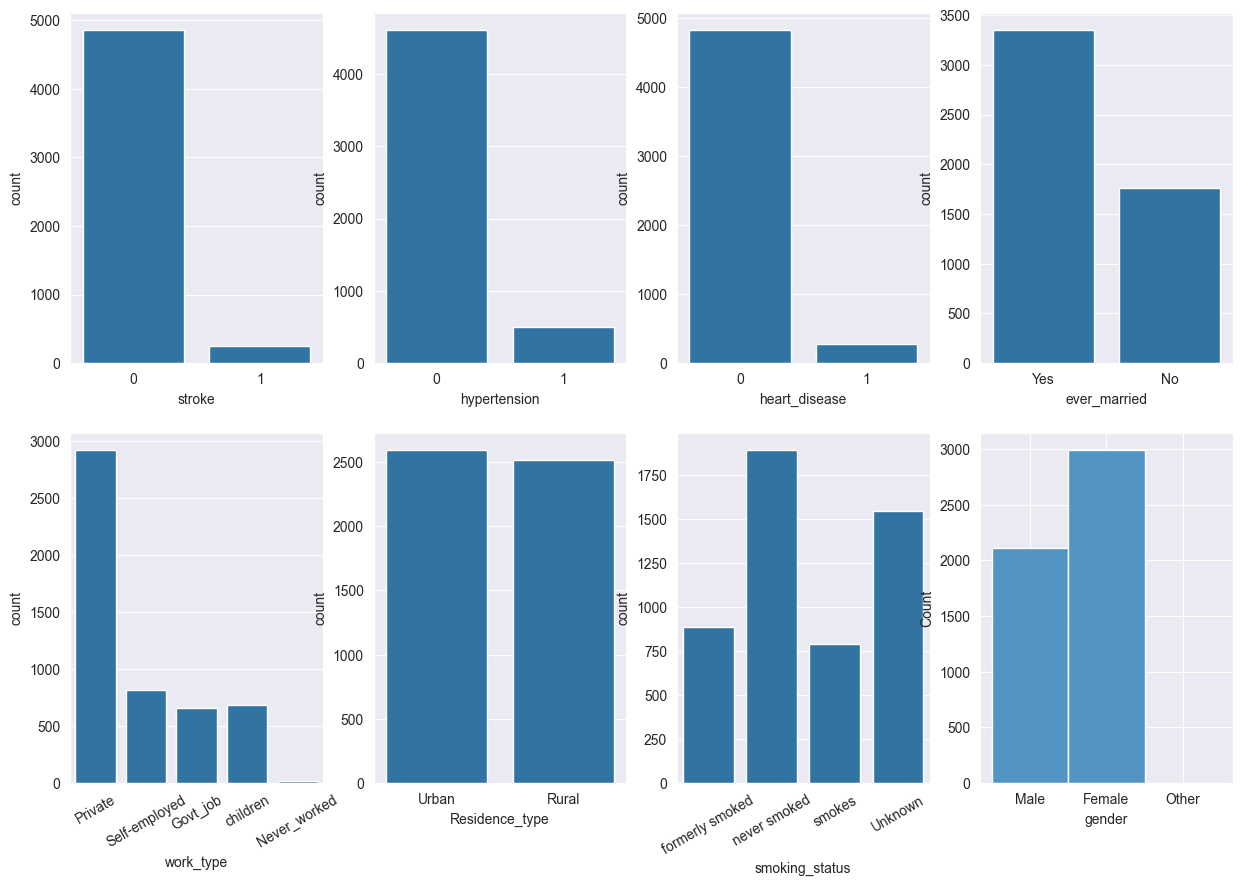

In [96]:
# Hacer las gráficas usando seaborn

# Crear la figura y los ejes:
fig, axes = plt.subplots(2, 4, figsize=(15, 10))

# Graficar cada variable:
sns.countplot(data = pandasDF, x="stroke", ax=axes[0, 0])
sns.countplot(data = pandasDF, x="hypertension", ax=axes[0, 1])
sns.countplot(data = pandasDF, x="heart_disease", ax=axes[0, 2])
sns.countplot(data = pandasDF, x="ever_married", ax=axes[0, 3])
sns.countplot(data = pandasDF, x="work_type", ax=axes[1, 0])

axes[1, 0].tick_params(axis='x', rotation=30)

sns.countplot(data = pandasDF, x="Residence_type", ax=axes[1, 1])
sns.countplot(data = pandasDF, x="smoking_status", ax=axes[1, 2])

axes[1, 2].tick_params(axis='x', rotation=30)

sns.histplot(data = pandasDF, x="gender", ax=axes[1, 3])

# Mostar las gráficas
plt.show()

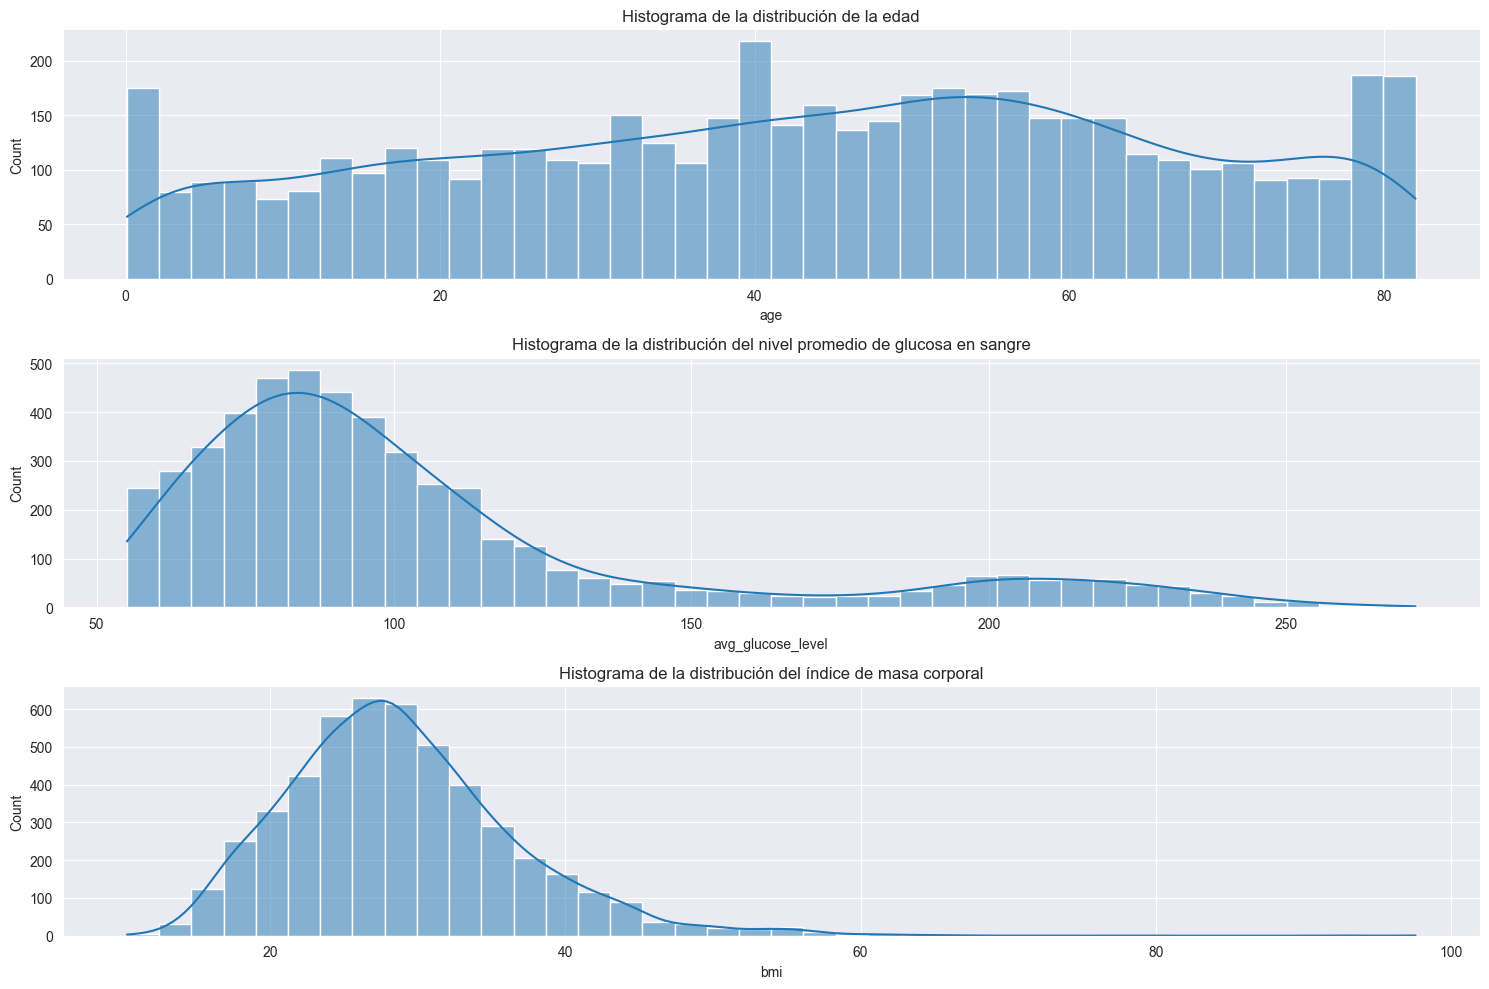

In [97]:
# Hacer los histogramas de las variables numéricas

fig, axes = plt.subplots(3, 1, figsize=(15, 10))

axes[0].set_title("Histograma de la distribución de la edad")
sns.histplot(pandasDF["age"], bins=40, kde=True, ax=axes[0])

axes[1].set_title("Histograma de la distribución del nivel promedio de glucosa en sangre")
sns.histplot(pandasDF["avg_glucose_level"], bins=40, kde=True, ax=axes[1])

axes[2].set_title("Histograma de la distribución del índice de masa corporal")
sns.histplot(pandasDF["bmi"], bins=40, kde=True, ax=axes[2])

# Ajustar automáticamente los subplots para evitar superposiciones
plt.tight_layout()

# Mostrar los histogramas
plt.show()

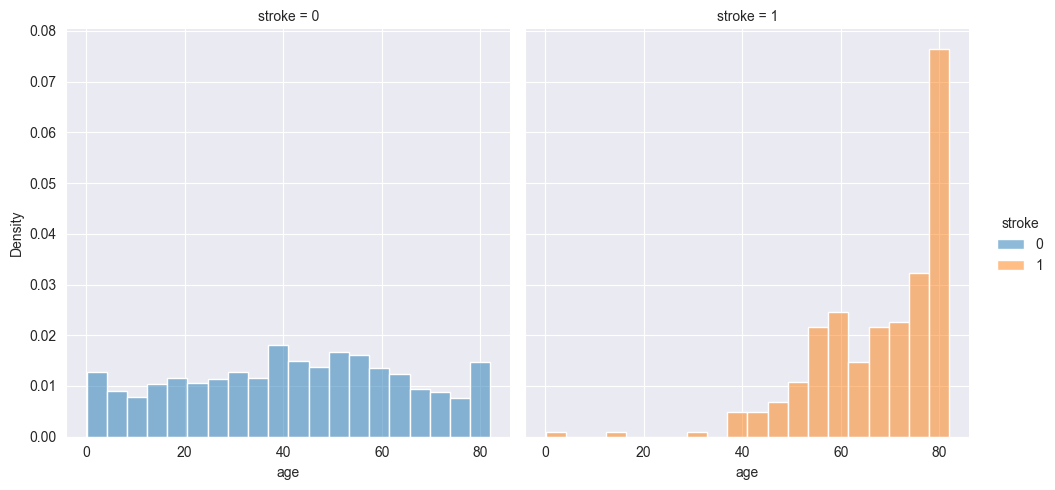

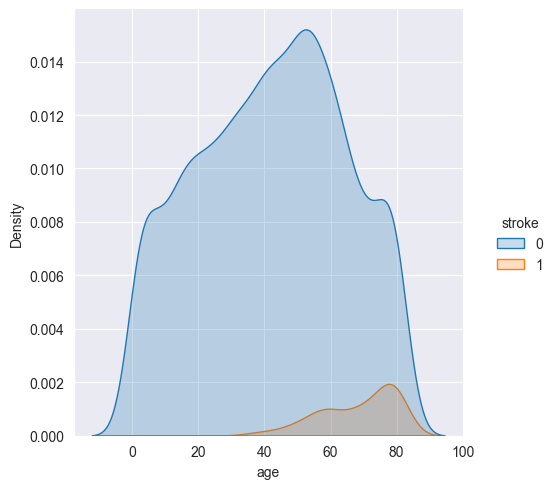

In [101]:
# Observación de la distribución de la variable "stroke" en relación a la edad.
sns.displot(pandasDF, x="age", hue="stroke", col="stroke", stat="density", common_norm=False)
sns.displot(pandasDF, x="age", hue="stroke", kind="kde", fill=True)

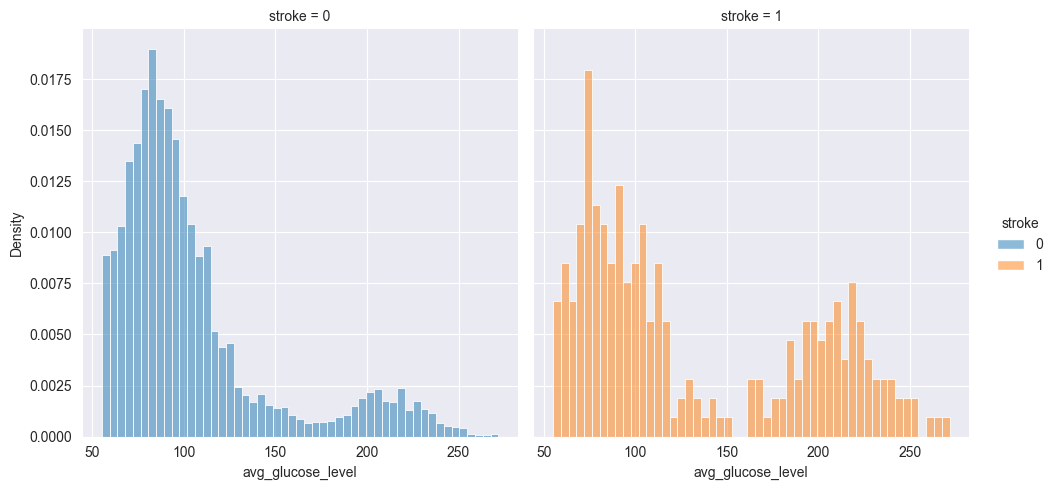

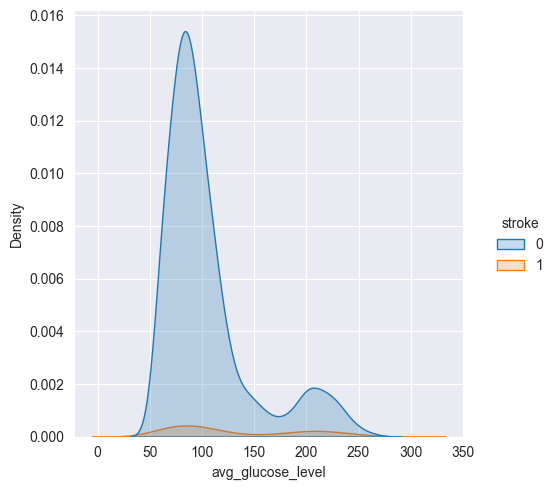

In [105]:
# Observación de la distribución de la variable "media de glucosa" en relación a la edad.
sns.displot(pandasDF, x="avg_glucose_level", hue="stroke", col="stroke", stat="density", common_norm=False)
sns.displot(pandasDF, x="avg_glucose_level", hue="stroke", kind="kde", fill=True)

In [107]:
# Crear una nueva columna llamada "Alto_Riesgo" que indique si una persona tiene alto riesgo de sufrir un ictus.
mlDF01 = mlDF.withColumn("Alto_Riesgo", when((col("age") >= 40) & (col("avg_glucose_level") > 125), 1).otherwise(0))

# Mostrar las primeras 5 filas del DataFrame
mlDF01.limit(5).toPandas()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,Alto_Riesgo
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,0
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,1


In [109]:
# Tratamiento de variables categóricas a numéricas

# Mostrar las primeras 5 filas del DataFrame
noCategoricas = ["age", "hypertension", "hearth_disease", "avg_glucose_level", "bmi", "stroke", "Alto_Riesgo"]

# Crear un StringIndexer para cada columna categórica
indices = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(mlDF01) for column in list(set(mlDF01.columns) - set(noCategoricas))]

# Crear un Pipeline con los StringIndexers
pipeML = Pipeline(stages=indices)

# Ajustar y transformar el DataFrame
mlDF02 = pipeML.fit(mlDF01).transform(mlDF01)

# Mostrar las primeras 5 filas del DataFrame
mlDF02.limit(5).toPandas()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,Alto_Riesgo,heart_disease_index,smoking_status_index,Residence_type_index,work_type_index,ever_married_index,gender_index
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,1,1.0,2.0,0.0,0.0,0.0,1.0
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1,1,0.0,0.0,1.0,1.0,0.0,0.0
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,0,1.0,0.0,1.0,0.0,0.0,1.0
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,1,0.0,3.0,0.0,0.0,0.0,0.0
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,1,0.0,0.0,1.0,1.0,0.0,0.0
